# Post Mortem Analysis. Я провёл дополнительный анализ после отправки тестового компании. Смотри в конец файла.


## А/Б тест   
В файле данные по АБ-тестированию, тест был направлен на улучшение конверсии и размеров платежей пользователей.  


Данные внутри:  
>uid - уникальный айди пользователя  
group - группа пользователей контроль/тест  
сountry - страна  
conversion - флаг конверсии в платеж  
payments - сумма платежа  


Задача: проанализировать тест понять какая группа лучше, стоит ли раскатывать изменения одной группы на всех пользователей. Достоверны ли полученные результаты?


---
## Решение

---
### Немного рассуждений

Перед началом анализа нам надо определить с некоторыми ограничениями.
1. Нам нужно сформулировать нулевую и альтернативную гипотезы(в том числе насколько большие изменения мы хотим видеть).  
Помним о "проблеме подглядывания". Гипотезы должны быть сформулированы до начала теста. Но!  
Никаких исторических данных у меня нет. Поэтому я планирую посмотреть на средние значения метрик у **КОНТРОЛЬНОЙ группы**, не глядя в тестовую. Просто для лучшего понимания задачи. 

2. Нужно решить, какое p-value и какую мощность теста мы хотим видеть. Тут далеко ходить не будем и скажем, что порог значимости p-value = 0.05,
мощность теста = 0.8. 

3. Тест был направлен и на улучшение конверсии, и на повышение размеров платежей пользователей.
Т.е. на самом деле это 2 метрики. Поэтому нам стоит использовать поправку для множественных сравнений при оценке теста.

---

---
### Preprocessing 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('mission2ab (1).xlsx')

In [ ]:
df.head()

,uid,group,country,conversion,payments
0,067939C6-68CE-9E62-9884-E3B5295D66F6,control,India,0.0,0.0
1,66DE3275-1C5C-4789-CBE4-62BED8904FC4,test,India,0.0,0.0
2,915A41CA-496F-BE66-9A0C-6A4316BF986B,test,India,0.0,0.0
3,EEE41B14-E897-27D5-9860-660542ED9DE9,test,India,0.0,0.0
4,BD642D24-4946-1717-1C23-130D69602876,test,India,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uid         1300 non-null   object 
 1   group       1300 non-null   object 
 2   country     1300 non-null   object 
 3   conversion  1300 non-null   float64
 4   payments    1300 non-null   object 
dtypes: float64(1), object(4)
memory usage: 50.9+ KB


Столбец 'payments' должен иметь тип float, а не object.

In [ ]:
df['payments'].unique()[:20]

array(['0.0', '3.95', '3.78', datetime.datetime(2022, 8, 1, 0, 0), '0.74',
       '2.56', datetime.datetime(2022, 2, 5, 0, 0), '4.63', '2.91',
       '0.61', '2.36', '0.48', '0.95', '2.62', '0.55',
       datetime.datetime(2022, 2, 1, 0, 0), '2.83',
       datetime.datetime(2022, 1, 14, 0, 0), '0.75', '11.95'],
      dtype=object)

Как видно, файл пришёл к нам с неправильным форматированием, часть чисел с плавающей точкой была занесена в таблицу в формате даты.
Нужно это исправить.

In [ ]:
to_nums = pd.to_numeric(df['payments'], errors='coerce') # get nans on cells with datetime

In [ ]:
date_index = to_nums.index[to_nums.apply(np.isnan)]  # get indexes of nans (of datetime values in df)
dates = df['payments'][date_index]
dates[:10]

23     2022-08-01 00:00:00
50     2022-02-05 00:00:00
95     2022-02-01 00:00:00
99     2022-01-14 00:00:00
207    2022-06-24 00:00:00
224    2022-07-11 00:00:00
238    2022-06-04 00:00:00
317    2022-01-03 00:00:00
340    2022-05-01 00:00:00
343    2022-11-06 00:00:00
Name: payments, dtype: object

Теперь нужно форматировать дату и получить значения float. Для этого надо из даты достать день и месяц в формате "дд.мм" и конвертировать в float.  

Просмотрев файл данных глазами, я вижу, что существует ещё одна проблема: в файле встречаются значения как 03.07, так и 8.1. Пандас читает их одинаково в формате 03.07, 08.01. То есть в некоторых случаях, когда месяц имеет одночисленный номер, мы теряем понимание, стоял ли он в разряде десятичной или сотой доли.  
 Т.о. если я сейчас склею месяц и день, то добавлю ошибку в данные. Мне придётся пойти на это, так как быстрого способа программно это исправить я не придумал.  
Поэтому будем работать с шумом. Благо он не появляется в целой части числа, только в дробной, которая < 1. 

In [ ]:
dates = pd.to_datetime(dates)
dates[:5]

23    2022-08-01
50    2022-02-05
95    2022-02-01
99    2022-01-14
207   2022-06-24
Name: payments, dtype: datetime64[ns]

In [ ]:
dates = dates.apply(lambda x: float(str(x.day) + '.' + str(x.month)))
dates[:5]

23      1.8
50      5.2
95      1.2
99     14.1
207    24.6
Name: payments, dtype: float64

In [ ]:
df.payments.iloc[dates.index] = dates

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df.payments = pd.to_numeric(df.payments)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uid         1300 non-null   object 
 1   group       1300 non-null   object 
 2   country     1300 non-null   object 
 3   conversion  1300 non-null   float64
 4   payments    1300 non-null   float64
dtypes: float64(2), object(3)
memory usage: 50.9+ KB


У нас получилось! Теперь можно работать с данными.

### EDA. Посмотрим немного на сами данные.
У нас не так много фич в данных, при этом мы не хотим подсматривать в тестовую группу до того, как выберем параметры A/B теста. 
Но размер выборки и распределение по странам посмотреть можно.

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)

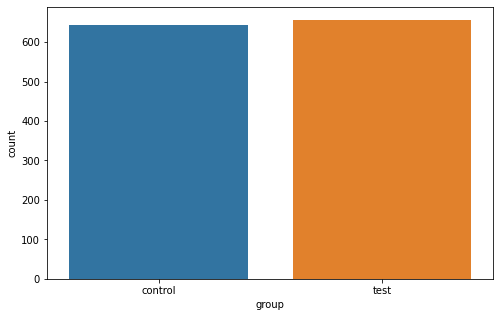

In [ ]:
sns.countplot(data=df, x='group');

In [ ]:
df.group.value_counts()

test       656
control    644
Name: group, dtype: int64

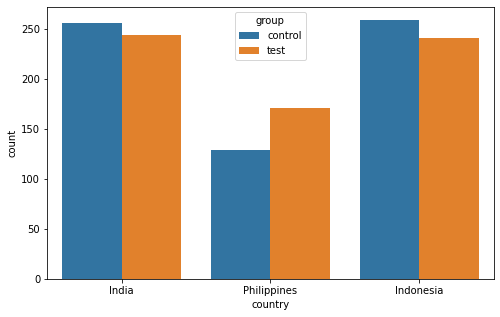

In [ ]:
sns.countplot(data=df, x='country', hue='group');

Видим, что выборки по размеру равные, ~650 наблюдений в каждой.  
По странам наблюдается небольшой дисбаланс, тестовая выборка доминирует в Филиппинах и слегка отстаёт в Индии и Индонезии по кол-ву записей.  
Надеюсь, A/A тест был проведён и стат.значимых различий в выборках предыдущий исследователь не заметил :)

Посмотрим на среднее значение чека и конверсии в КОНТРОЛЬНОЙ выборке.  
Также интересно узнать, насколько это значение зависит от страны.

In [ ]:
control = df[df.group == 'control']

In [ ]:
conv_control = control[['country', 'conversion']].groupby(by='country').sum()
conv_control = conv_control.reset_index()

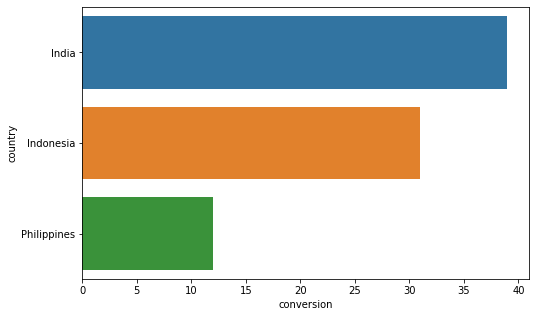

In [ ]:
sns.barplot(data=conv_control, x='conversion', y='country');

In [ ]:
conv_control

,country,conversion
0,India,39.0
1,Indonesia,31.0
2,Philippines,12.0


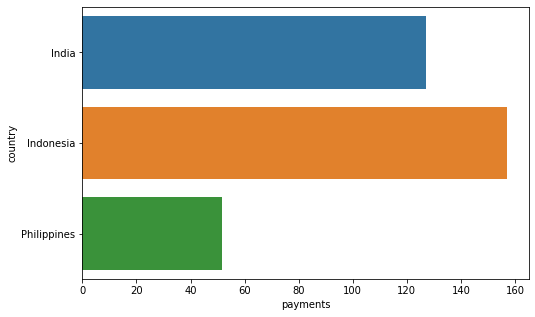

In [ ]:
pay_control = control[['country', 'payments']].groupby(by='country').sum()
pay_control = pay_control.reset_index()
sns.barplot(data=pay_control, x='payments', y='country');

In [ ]:
pay_control

,country,payments
0,India,127.16
1,Indonesia,157.20
2,Philippines,51.81


Возможно, это не самые показательные графики, т.к. количество наблюдений в странах разное.  
Лучше мы нарисуем конверсию/количество_клиентов, т.е. процент конверсии для каждой страны. И также средний доход с человека для каждой страны.

In [ ]:
client_per_country = control.groupby(by='country').count()['conversion'].values

In [ ]:
conv_control['conversion_percent'] = conv_control['conversion'] / client_per_country
conv_control

,country,conversion,conversion_percent
0,India,39.0,0.152344
1,Indonesia,31.0,0.119691
2,Philippines,12.0,0.093023


In [ ]:
pay_control['avg_payment'] = pay_control['payments'] / client_per_country
pay_control

,country,payments,avg_payment
0,India,127.16,0.496719
1,Indonesia,157.20,0.606950
2,Philippines,51.81,0.401628


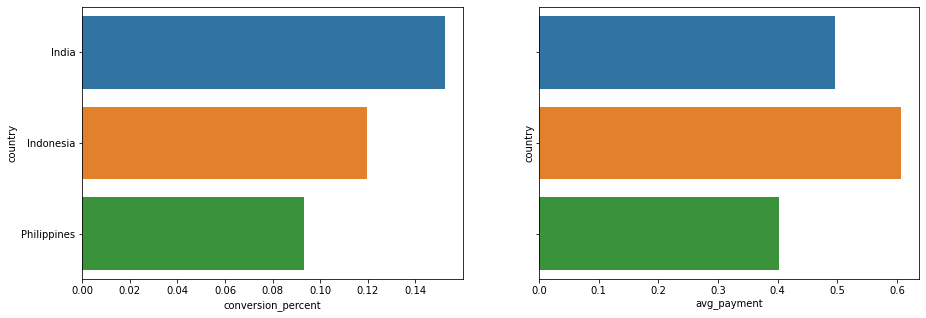

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
fig, axes = plt.subplots(1, 2, sharey=True)
# fig = plt.figure(figsize=(8, 10))
sns.barplot(data=conv_control, x='conversion_percent', y='country', ax=axes[0])
sns.barplot(data=pay_control, x='avg_payment', y='country', ax=axes[1])
plt.show();

На этих графиках наглядно видно, что средний клиент каждой страны отличается.  
В Индии часто заходят посмотреть на услугу, увеличивая нам конверсию. 
Клиенты из Индонезии более платёжеспособные и приносят нам больше денег в среднем.  
Филиппинцы отстают во всём от двух других стран.  

Напомню, что в тестовой группе филиппинцев больше, чем в контрольной, клиентов же из Индии и Индонезии в тесте меньше. Вообще говоря, это может исказить наше предположение, что группы теста и контроля гомогенны.

Но мы доверимся тем, кто собирал данные и создавал выборку и будем считать, что группы по природе своей однородны и что на изменения в показателях влияет только случайность и наше воздействие на тестовую группу.

Изучим также исторические средние значения(средние значения контрольной группы) для конверсии и чека, которые поздней будем использовать для формулирования гипотез.

In [ ]:
control.describe()

,conversion,payments
count,644.000000,644.000000
mean,0.127329,0.522003
std,0.333600,1.916929
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,22.770000


Нас также интересует нормальность распределения данных и гомогенность дисперсий в группах. Это важно для проведения t-testа, например.

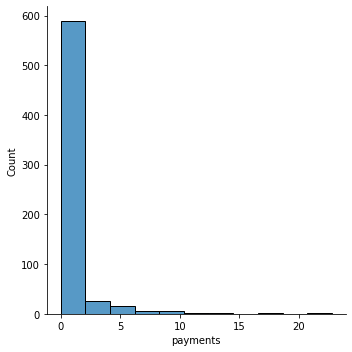

In [ ]:
sns.displot(data=control, x='payments');

In [ ]:
from scipy.stats import levene

_, conv_p_value = levene(control['conversion'],  df[df.group == 'test']['conversion'], center='median')
_, pay_p_value = levene(control['payments'],  df[df.group == 'test']['payments'], center='median')
conv_p_value, pay_p_value

(0.0008856044551950971, 0.0003674848649422895)

Из графика и теста Левене видно, что данные распределены не нормально и дисперсии не гомогенны(маленькое p-value у Левене говорит нам о непринятии нулевой гипотезы о равности дисперсий).
t-test тут использовать нельзя.

---
### Гипотезы и параметры теста

In [ ]:
control.conversion.sum(), control.payments.sum()

(82.0, 336.17)

Мы немного посмотрели на данные. Что мы знаем:
*   Рамер выборки ~650 
*   Исторический mean и std для конверсии: 0.127 и 0.337
*   Исторический mean и std для чека: 0.522 и 1.917
*   Порог p-value = 0.05, мощность теста = 0.8



И тут я заметил, что в задании не сказано о том, какой MDE(минимальный эффект) мы бы хотели задетектировать для того, чтобы считать тест успешным. Поэтому будем просто рассматривать случай, когда выборки отличаются больше, чем на 0.

#### Определим гипотезы. (HA - hypothesis alternative)
>1. H0-1 гипотеза: "Группы не отличаются по уровню конверсии."  
2. H0-2 гипотеза: "Группы не отличаются по уровню среднего чека."

Будем проводить двусторонний A/B тест. 
> 1. HA-1 гипотеза: "В тестовой группе конверсия отличается от конверсии в контрольной группе больше, чем на 0."  
2. HA-2 гипотеза: "В тестовой группе средний чек отличается от чека в контрольной группе больше, чем на 0."

---

>
Наконец мы можем немножко посмотреть на тестовую группу!

### Визуализация разницы теста и контроля

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)

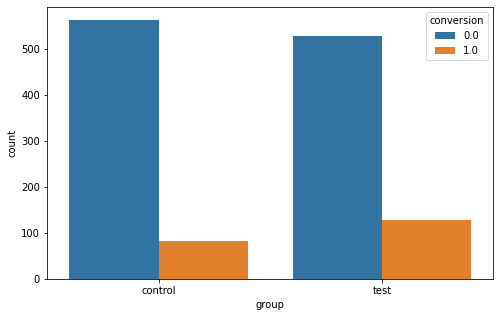

In [ ]:
sns.countplot(data=df, x='group', hue='conversion');

In [ ]:
pd.crosstab(df['group'], df['conversion'], normalize=True)

conversion,0.0,1.0
group,,
control,0.432308,0.063077
test,0.406154,0.098462


In [ ]:
df[['group', 'payments']].groupby(by='group').sum()

,payments
group,
control,336.17
test,719.57


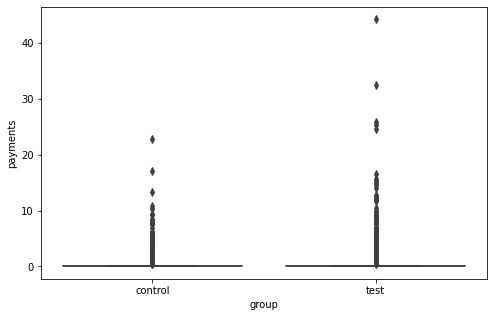

In [ ]:
sns.boxplot(data=df, y='payments', x='group');

Нулевые значения слишком сильно "скашивают" распределение, давайте посмотрим график только для тех, где покупка была совершена.

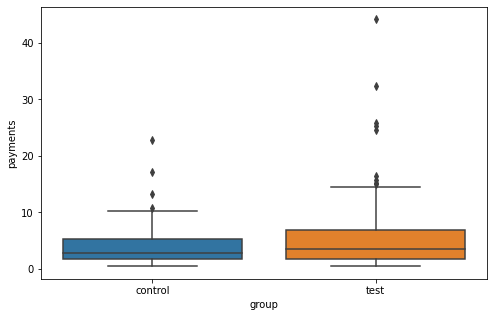

In [ ]:
sns.boxplot(data=df[df['conversion'] == 1], y='payments', x='group', order=['control', 'test']);

По графикам и таблицам можно увидеть некоторую разницу.  
Процент конверсии увеличился, это видно. 

Средний чек по медиане всё ещё выглядит сравнительно похожим для теста и контроля, но хвост дорогих покупок(точек-выбросов на графике) увеличился для теста почти в два раза.

---

## Bootstrap

Давайте посмотрим, насколько значимы различия. Т.к. дисперсии не гомогенны и данные не распределены нормально, мы не будем использовать t-test. 

Используем бутстрап и посмотрим на разницы средних значений. Если их доверительные интервалы не пересекаются с нулём, то разница в группах будет статистически значимой.

Используем вот такой бутстрап для двусторонней проверки гипотезы, оценивающий разницу двух групп с визуализацией доверительных интервалов.

In [ ]:
from tqdm import tqdm
from scipy.stats import norm

def get_bootstrap(
    data_column_1, # first group samples
    data_column_2, # second group samples
    boot_it = 1000, # amount of bootstrap iterations
    statistic = np.mean, # statistic we are looking for
    bootstrap_conf_level = 0.95 # confidence level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # extraction of subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # with returns because it's bootstrap
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    # plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### Разница в проценте конверсии

100%|██████████| 1000/1000 [00:00<00:00, 3736.27it/s]


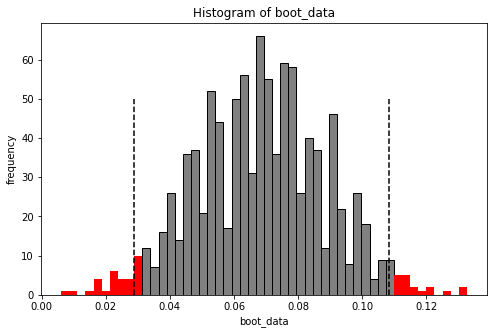

P_VALUE =  0.000665004264425774


In [ ]:
booted_data = get_bootstrap(
    df[df['group'] == 'test']['conversion'],
    df[df['group'] == 'control']['conversion'],
)
print('P_VALUE = ', booted_data['p_value'])

#### Разница с среднем чеке

100%|██████████| 1000/1000 [00:00<00:00, 3441.67it/s]


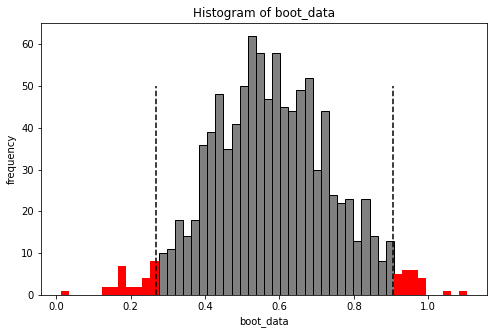

P_VALUE =  0.0003585642598614141


In [ ]:
booted_data = get_bootstrap(
    df[df['group'] == 'test']['payments'],
    df[df['group'] == 'control']['payments'],
)
print('P_VALUE = ', booted_data['p_value'])

## Выводы
Очевидно, что по обеим метрикам мы получили статистически значимые различия!  
Даже если мы применим самую консервативную поправку Бонферрони, оба полученных p-value находятся ниже, чем 0.025 = 0.05/2 (Бонферрони для двух тестов).

Отлично, таким образом мы принимаем обе альтернативные гипотезы.  
Наше улучшение для тестовой группы показало себя отлично. Можно выкатывать его на прод, ура!

*Последнее замечание*: метрики конверсии и среднего чека связаны друг с другом. Об этом стоит помнить, т.к увеличение конверсии само по себе увеличивает средний чек на одного пользователя даже в случае, если распределение средних чеков остаётся тем же. 
Я не уверен, надо ли оценивать и показывать эту связь. Возможно, тут стоит советоваться с бизнесом.

---
---
---
## Post Mortem Analysis (я провёл этот анализ после отправки тестового компании)
Что ещё можно было бы посмотреть?

Т.к. одна из будущих задач на позиции, про которые говорили, -- это кластеризация клиентов, то наверняка на что-то такое хотели посмотреть и на тестовом.  

Мы видели на графиках, что клиенты из разных стран отличаются по метрикам, которые хотим предсказывать.
Способов делить данные на кластеры с предоставленным датасетом не то чтобы много. Для этого подходит только фича "country". В принципе стоило по ней разбить данные на группы и провести по A/B тесту для каждой страны отдельно.  
Попробуем? :)


In [ ]:
df.country.value_counts()

India          500
Indonesia      500
Philippines    300
Name: country, dtype: int64

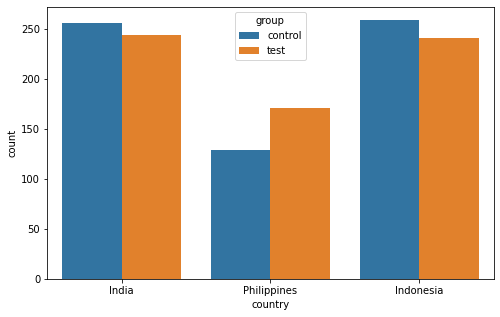

In [ ]:
sns.countplot(data=df, x='country', hue='group');

In [ ]:
pd.crosstab(df['group'], df['country'], margins=True)

country,India,Indonesia,Philippines,All
group,,,,
control,256,259,129,644
test,244,241,171,656
All,500,500,300,1300


Повторяюсь: Индия и Индонезия имеют похожие выборки для теста и контроля, Филлипины же не совсем сбалансированы.  
Для бутстрапа это не является очень большой проблемой. 

---

В итоге давайте проведём 6 экспериментов: для каждой страны из 3-ёх и каждой метрики из 2-ух.  

Примем также поправку Бонферрони. Всего у нас 3 набора данных, 3 кластера клиентов из разных стран. Для каждого кластера мы хотим проверить по 2 гипотезы: на процент конверсии и на размер платежа. Для каждого кластера применяем Бонферрони. p-value = 0.05 / 2 = 0.025



In [ ]:
fixed_p_val = 0.05 / 2
print(fixed_p_val)

conf_interval = 1 - fixed_p_val
print(conf_interval)

0.025
0.975


#### Посмотрим на конверсию

100%|██████████| 1000/1000 [00:00<00:00, 4206.53it/s]


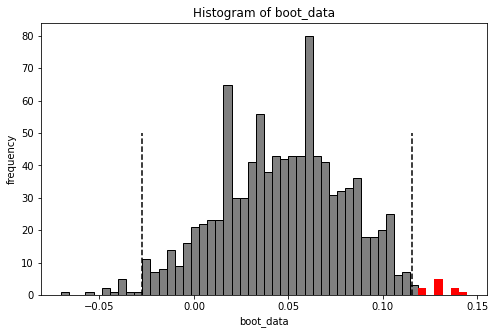

India: P_VALUE =  0.1642052445518698

********************


100%|██████████| 1000/1000 [00:00<00:00, 4234.05it/s]


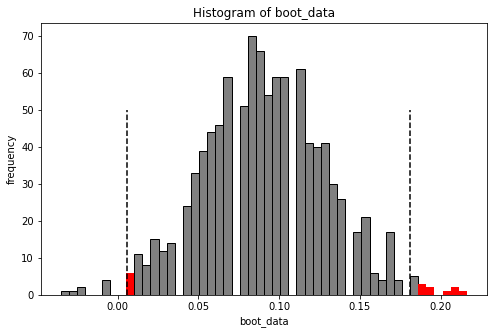

Philippines: P_VALUE =  0.017004314663693728

********************


100%|██████████| 1000/1000 [00:00<00:00, 4314.22it/s]


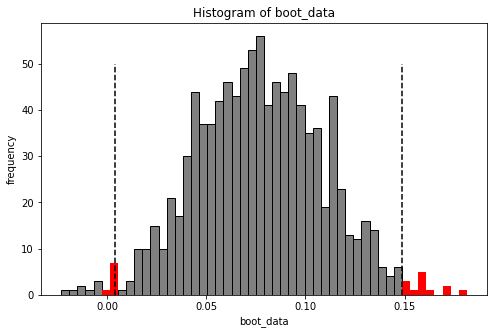

Indonesia: P_VALUE =  0.016394607850977023

********************


In [ ]:
conversion_hypothesis = {}
for country in df.country.unique():
    # print(country)
    booted_data = get_bootstrap(
    df[(df['group'] == 'test') & (df['country'] == country)]['conversion'],
    df[(df['group'] == 'control') & (df['country'] == country)]['conversion'],
    bootstrap_conf_level= conf_interval)
    print(f'{country}: P_VALUE = ', booted_data['p_value'])
    print('\n', '*' * 20, sep='')

    conversion_hypothesis[country] = (booted_data['p_value'] <= fixed_p_val)

#### Посмотрим на размер платежей

100%|██████████| 1000/1000 [00:00<00:00, 4539.79it/s]


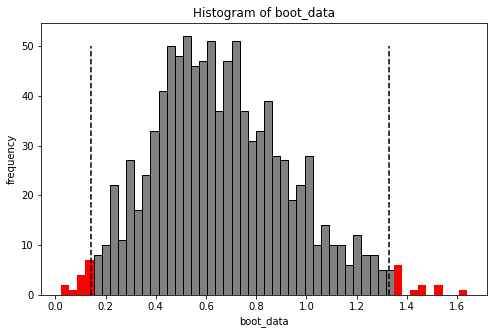

India: P_VALUE =  0.015040326344987283

********************


100%|██████████| 1000/1000 [00:00<00:00, 3920.52it/s]


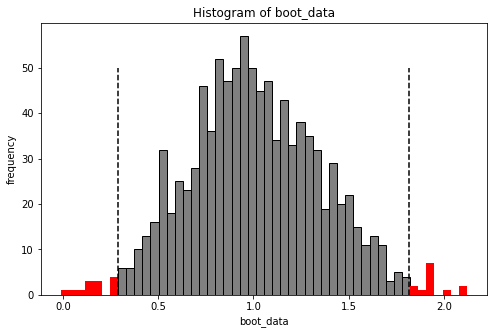

Philippines: P_VALUE =  0.0037067856176270534

********************


100%|██████████| 1000/1000 [00:00<00:00, 4424.30it/s]


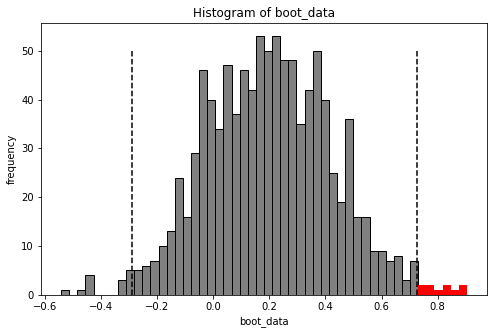

Indonesia: P_VALUE =  0.3716594233681001

********************


In [ ]:
payments_hypothethis = {}
for country in df.country.unique():
    # print(country)
    booted_data = get_bootstrap(
    df[(df['group'] == 'test') & (df['country'] == country)]['payments'],
    df[(df['group'] == 'control') & (df['country'] == country)]['payments'],
    bootstrap_conf_level= conf_interval)
    print(f'{country}: P_VALUE = ', booted_data['p_value'])
    print('\n', '*' * 20, sep='')

    payments_hypothethis[country] = booted_data['p_value'] <= fixed_p_val

#### Что мы видим?

In [ ]:
results = pd.DataFrame([conversion_hypothesis, payments_hypothethis], index=['conversion', 'payments'])
results

,India,Philippines,Indonesia
conversion,False,True,True
payments,True,True,False


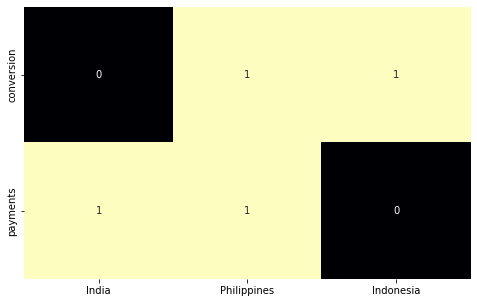

In [ ]:
sns.heatmap(results, annot=True, cbar=False, square=False, cmap='magma');

Для каждого кластера мы провели свой A/B тест с множественными гипотезами.
В итоге можем сказать, что:
1. Филлипины прошли проверку стат.значимости для конверсии и для платежей.
2. Для кластера Индии результаты платежей отличаются стат.значимо, но конверсия -- нет.
3. Для Индонезии конверсия прошла проверку стат.значимости, а платежи -- нет.

#### Лог-нормальное распределение
Платежи можно прологарифмировать и посмотреть на то, какое распределение получилось.
Скорее всего получим что-то, похожее на норм.распределение. И тогда можно использовать параметрические тесты типа t-теста.

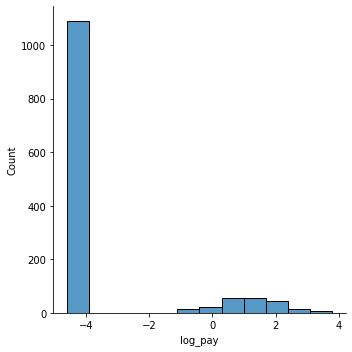

In [ ]:
df['log_pay'] = df['payments'].apply(lambda x: np.log(x + 0.01 if x == 0 else x))
sns.displot(data=df, x='log_pay');

нуу, не совсем нормально, я бы сказал

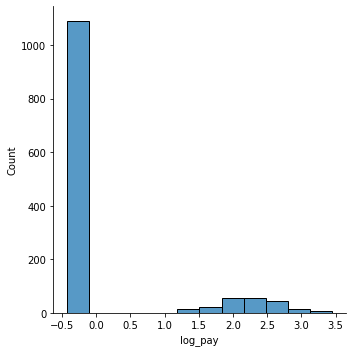

In [ ]:
import scipy.stats as stats
df['log_pay'] = stats.zscore(df['log_pay'])
sns.displot(data=df, x='log_pay');

Распределение не выравнивается, поэтому оставим задумку.  
Но по идее можно откинуть все 0-значения. И работать с пользователями, которые платят. Правда, получится другая метрика: Average Revenue Per Paying User, ARPPU. Но она тоже очень полезна.

#### Что ещё можно было попробовать?

* Я думал над тем, чтобы также поиграться с отсечением хвостовых частей выборки и проведением тестов для оставшейся части. Это может помочь с устойчивостью тестов.

* Попробовать метод Холма или метод Бенджамини—Хохберга для множественных сравнений. Но в данном случае с 2 гипотезами Бонферрони не сильно штрафует, поэтому в другой раз.

* ANOVA для того, чтобы удостовериться, что показатели по странам отличаются?


#### Финальные мысли и замечания:
1. Думал ещё использовать U-критерий Манна—Уитни для платежей. Но мне подсказали, что он не подходит, т.к. у платежей очень много 0-значений. Поэтому ранги у всех этих значений буду одинаковые и это собьёт тест.
2. Вообще говоря в продакшн-системах для выбора теста используют симуляции, где прогоняют сгенерированные или исторические данные через разные критерии для понимания того, какой тест чаще даёт ошибки I-го и II-го рода. Это надёжней, чем исходить из "лучших практик использования" при выборе критериев.
3. В продакшене также часто нет возможности раскатывать какую-то фичу по-разному для разных стран. Так как дорого и поддерживать много версий продукта слишком накладно. Новую фичу надо раскатывать на всех, если она в среднем даёт лучший показатель. Хотя так бывает не всегда, например, разослать разные версии маркетинговых писем для разных категорий людей мы можем -- это одноразовое действие.  
Если всё же мы смотрим фичу в целом, то тут лучше было бы не делить клиентов на разные страны, а ориентироваться на первоначальную версию теста, где у нас нет разбивки по странам.  
    **ВАЖНО:** вторую версию теста с 3-мя когортами можно использовать для внутреней аналитики. Т.к. мы видим, что вообще говоря у нас по когортам не все тесты окрасились в зелёный (т.е. не дали улучшение метрики), мы можем сделать заметку на будущее для того, чтобы провести позже **обратный тест**. Он поможет проконтролировать метрики и скажет, не упали ли они там, где наша фича не дала стат.результат улучшений.